# This code:

1. Calculates the water thickness 
2. Calculates the change in water elevation between consecutive time steps 
3. Computes the isostatic response associated to water thickness change
4. Plots the spatial distribution of the isostatic response at a give time step



In [43]:
import gflex
import pandas as pd
import numpy as np
import re 
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scripts import morphoGrid_sl as morph

import morphoGrid as morpho


from scipy.spatial import cKDTree

import time
from IPython.display import Image


# display plots in SVG format
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

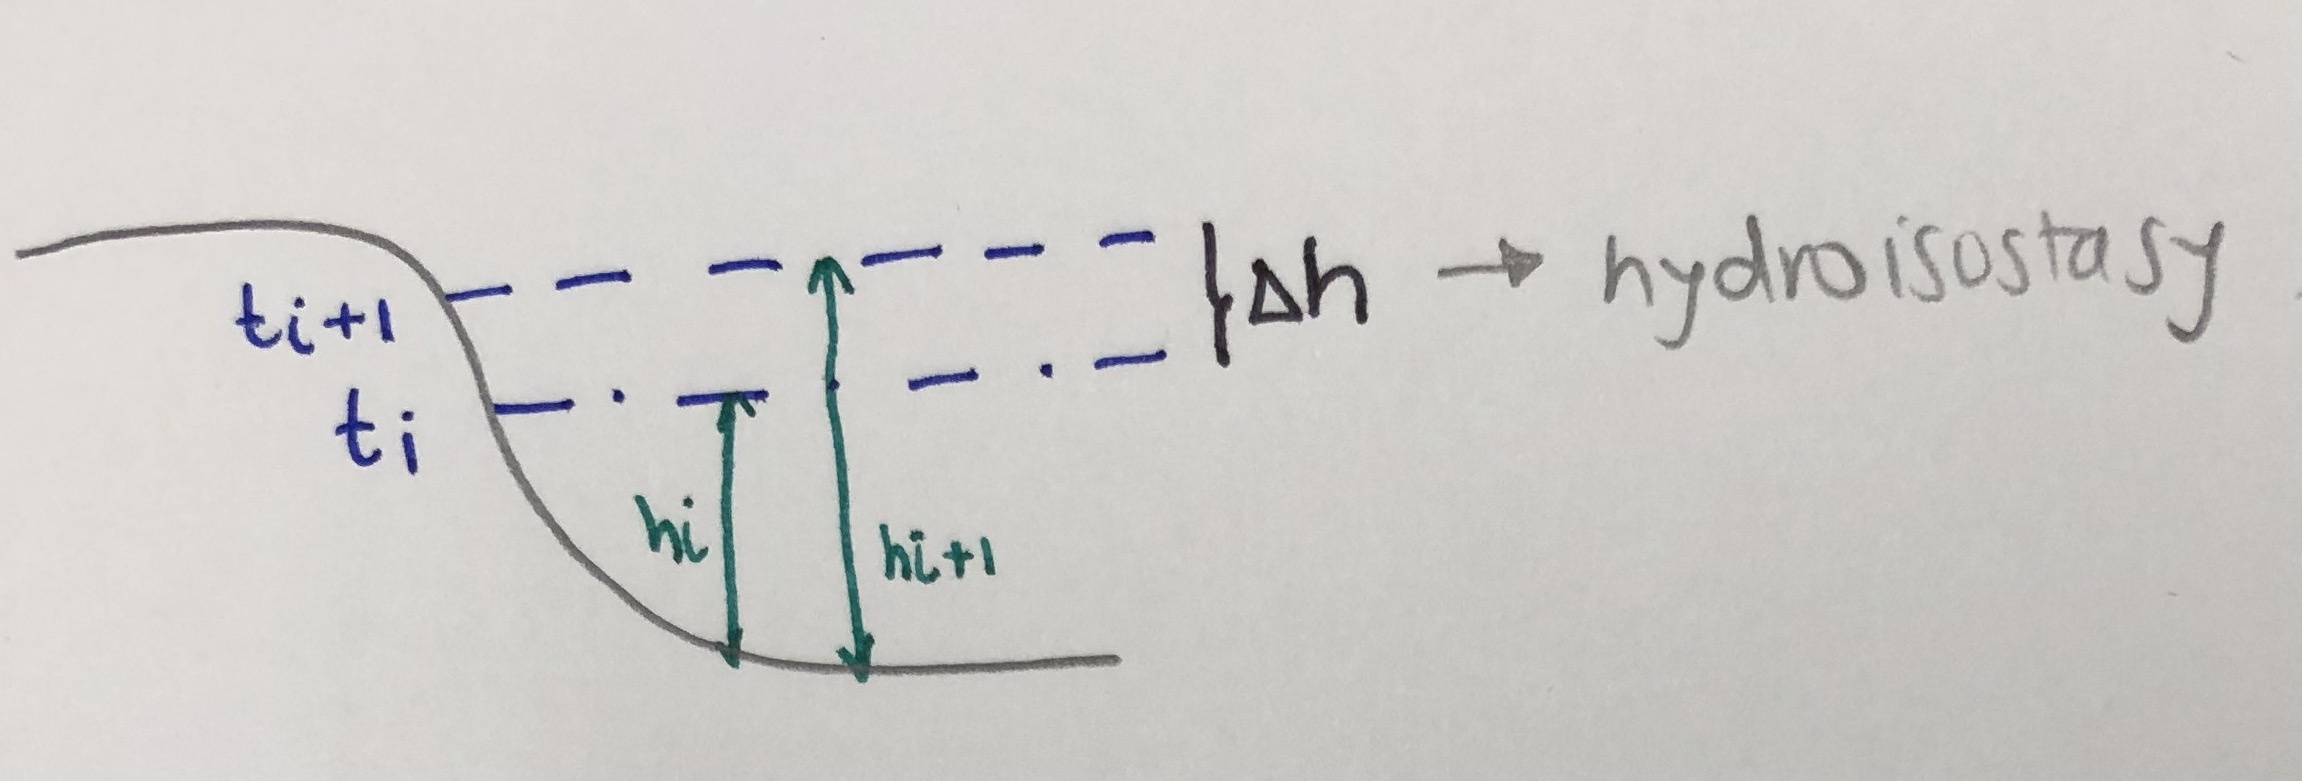

In [2]:
Image('/live/share/Badlands_simulations/Delta_2020/Delta_analysis/hydroisostasy/figures/hydroisostasy_cartoon.jpg', width=400, height=400)

In [3]:
# Parameters for gflex

poisson = 0.25 
youngMod = 100e9
mantleDensity = 3300.0
sedimentDensity = 2170.0
elasticT = 50.
boundary_W = 'Mirror'
boundary_E = 'Mirror'
boundary_S = 'Mirror'
boundary_N = 'Mirror'

In [4]:
path='/live/share/Badlands_simulations/Delta_2020'

simStep = 120  # The number of steps in your simulation
dx = 1e4 # The resolution you want based on your simulation

In [5]:
#Define a function to compute the isostatic response associated to water thickness change¶
def getWaterChangeFlex(waterDH):
    
    flex = gflex.F2D()
    # Set-up the grid variable
    flex.dx = dx
    flex.dy = dx

    # Solution method finite difference
    flex.Method = "FD"
    flex.Quiet = True

    # van Wees and Cloetingh (1994)
    flex.PlateSolutionType = "vWC1994"
    flex.Solver = "direct"

    # Acceleration due to gravity
    flex.g = 9.8
    # Poisson's Ratio
    flex.nu = poisson
    # Infill Material Density
    flex.rho_fill = 0.0
    # Young's Modulus
    flex.E = youngMod
    # Mantle Density
    flex.rho_m = mantleDensity
    # Sediment Density
    rho_s = sedimentDensity
    # Sea Water Density
    rho_w = 1029.0

    Te = elasticT * np.ones(waterDH.shape)

    flex.Te = Te

    # Surface load stresses
    flex.qs = np.zeros(waterDH.shape, dtype=float)

    # Boundary conditions
    flex.BC_W = boundary_W
    flex.BC_E = boundary_E
    flex.BC_S = boundary_S
    flex.BC_N = boundary_N

    # Compute surface loads
    flex.qs = (rho_w * flex.g * waterDH)
    
    flex.initialize()
    flex.run()
    flex.finalize()
    
    return flex.w

In [44]:
step=100

morpho = morpho.morphoGrid(folder=badlands_run, bbox = None, dx=dx)
morpho.loadHDF5(timestep=step)

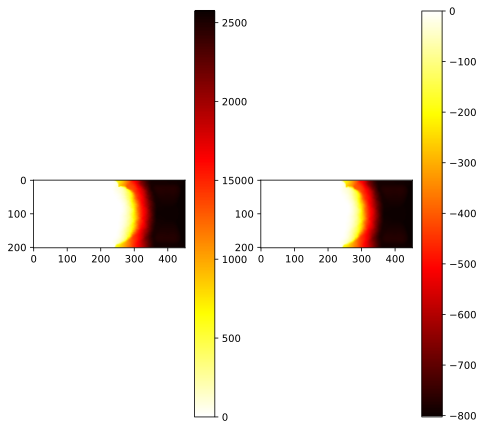

In [35]:
#unpacking the function ONE more time!!
badlands_run=path+'/Delta_running/IH_GH/Delta_SL_IH_Te50/h5'
step=100
waterChange =[] # Consecutive change in water elevation between consecutive time steps
elevation=[]
sedwater_flex=[] # sediment and water flex
    
badland_topo = morph.morphoGrid(folder=badlands_run, bbox = None, dx=dx)
badland_topo.loadHDF5(timestep=step)




elevation.append(badland_topo.z-badland_topo.sl)
sedwater_flex.append(badland_topo.flexure)
waterH = np.zeros(badland_topo.z.shape)
#finds the indeces of the marine part of the domain 
marine = np.where(badland_topo.z < badland_topo.sl)
#calulates the water column by sustracting the sea-level (badland_topo.sl) from the bathymetry(badland_topo.z[marine])
waterH[marine] = badland_topo.sl - badland_topo.z[marine]

#
fig,(ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(19/2.54,19/2.54))

waterflex = []

waterflex=(getWaterChangeFlex(waterH))
plt.imshow(waterflex)

im1=ax1.imshow(waterH, 'hot_r')
cbar = plt.colorbar(im1, ax=ax1)

im2=ax2.imshow(waterflex, 'hot')
cbar = plt.colorbar(im2, ax=ax2)

In [26]:
#making a function

waterChange =[] # Consecutive change in water elevation between consecutive time steps
elevation=[]
sedwater_flex=[] # sediment and water flex

def waterload(badlands_run, simStep, interval):
    for step in np.arange(0,simStep, interval):

        badland_topo = morph.morphoGrid(folder=badlands_run, bbox = None, dx=dx)
        badland_topo.loadHDF5(timestep=step)

        #Have to load the flexure with a separate morphogrid because otherwise the flexure is all weird
#         morpho = morpho.morphoGrid(folder=badlands_run, bbox = None, dx=dx)
#         morpho.loadHDF5(timestep=step)

        waterH = np.zeros(badland_topo.z.shape)
        #finds the indeces of the marine part of the domain 
        marine = np.where(badland_topo.z < badland_topo.sl)
        #calulates the water column by sustracting the sea-level (badland_topo.sl) from the bathymetry(badland_topo.z[marine])
        waterH[marine] = badland_topo.sl - badland_topo.z[marine]
        waterflex = []

    #     waterflex=(getWaterChangeFlex(waterH))
        waterflex.append(getWaterChangeFlex(waterH))
        print(np.shape(waterflex))
        
        plt.imshow(waterflex[step])


In [25]:
badlands_run=path+'/Delta_running/IH_GH/Delta_SL_IH_Te50/h5'

waterload(badlands_run,120, 40 )

(1, 202, 452)
(1, 202, 452)
(1, 202, 452)


IndexError: list index out of range

In [ ]:
plt.imshow(waterflex[0])

In [15]:
np.shape(waterflex)

(202, 452)

In [ ]:
fig,axes = plt.subplots(nrows=4,ncols=2, figsize=(19/2.54,19/2.54))
plt.rcParams['font.size'] = 7; plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42#     ploting_steps=[1*interval,3*interval,6*interval,9*interval]
plotting_steps=[24,49,74,100]

for count, p_step in enumerate(plotting_steps):
#         #Plotting sea-level difference
    im2= axes.T[0][count].imshow(waterChange[(p_step*interval)], cmap ='seismic', interpolation ='nearest',


im1=plt.imshow(waterH, 'hot_r')
cbar = plt.colorbar(im1)


In [ ]:
im2=plt.imshow(waterflex, 'hot')
cbar = plt.colorbar(im2)

In [ ]:
badland_topo.sl

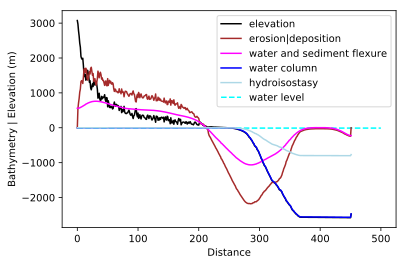

In [48]:
plt.plot(badland_topo.z[100,:], color= 'k', label='elevation')
plt.plot(badland_topo.cumchange[100,:]*-1, color='brown', label='erosion|deposition')
plt.plot(morpho.flexure[100,:], color='magenta', label='water and sediment flexure')


plt.plot(waterH[100,:]*-1, color='blue', label='water column')
plt.plot(waterflex[100,:], color='lightblue', label='hydroisostasy' )

plt.hlines(badland_topo.sl, xmin=0, xmax=500, color='cyan', linestyle='--', label='water level')

plt.legend()

plt.xlabel('Distance')
plt.ylabel('Bathymetry | Elevation (m)')

pass

In [ ]:
# This function:
#     1. Calculates the water thickness by calculating the change in water elevation between consecutive time steps
#     2. Computes the isostatic response associated to water thickness change
#     3. Plots the spatial distribution of the change in water elevation and isostatic response at a series of timesteps
#     4. Saves the plot as a pdf 

def hydroflex_waterDH (badlands_run, SL, interval, plotting_steps, color_SL):
    
#1. Calculate the water thickness 
    waterChange =[] # Consecutive change in water elevation between consecutive time steps
    elevation=[]
    sedwater_flex=[] # sediment and water flex
    for step in np.arange(0,simStep, interval):
#         if step % 5 == 0:
#         print('Processing step:',step)
        badland_topo = morph.morphoGrid(folder=badlands_run, bbox = None, dx=dx)
        badland_topo.loadHDF5(timestep=step)
        
        elevation.append(badland_topo.z-badland_topo.sl)
        sedwater_flex.append(badland_topo.flexure)
        waterH = np.zeros(badland_topo.z.shape)
        #finds the location of the marine part of the modeling domain by finding the locations where the bathymetry is smaller than the sea-level  
        marine = np.where(badland_topo.z < badland_topo.sl)
        #calculates the water column by substracting the sea-level from the bathymetry    
        waterH[marine] = badland_topo.sl - badland_topo.z[marine]
        #The  water column in the subsequent steps is the thickness change 
        else:
            #creates an empty array that has the same shape as the modeling domain (badland_topo.z.shape)
            waterH = np.zeros(badland_topo.z.shape)
            #finds the indeces of the marine part of the domain 
            marine = np.where(badland_topo.z < badland_topo.sl)
            #calulates the water column by sustracting the sea-level (badland_topo.sl) from the bathymetry(badland_topo.z[marine])
            waterH[marine] = badland_topo.sl - badland_topo.z[marine]
            #Need to get clarity as to why I can have 'oldwaterH' without creating an empty list or array before hand
            #This where the difference in water thicknes is calculated
            waterDH = waterH-oldwaterH
            #WaterChange is where the difference in water thicknes (waterDH) is stored
            waterChange.append(waterDH)
            #create a copy of the old water column (oldwaterH) so that it can be used in the calculation of the previous time step 
        oldwaterH = waterH.copy() 
#2. Compute the flexural isostasy associated with this change in water thickness for each time step
    waterflex = []
    for step in np.arange(0,simStep-1, interval):

#         if step % 5 == 0:
#         print('Processing step:',step)
        #Calling the waterChange for each time step  
        waterDH = waterChange[step]
        #Calculating and storing the flexural isostasy associated with the water thickness for each time step
        waterflex.append(getWaterChangeFlex(waterDH))
        
        
#3. Plotting water change and hydroisostasy maps
    fig,axes = plt.subplots(nrows=4,ncols=2, figsize=(19/2.54,19/2.54))
    plt.rcParams['font.size'] = 7; plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42#     ploting_steps=[1*interval,3*interval,6*interval,9*interval]
    plotting_steps=[24,49,74,100]

    for count, p_step in enumerate(plotting_steps):
#         #Plotting sea-level difference
        im2= axes.T[0][count].imshow(waterChange[(p_step*interval)], cmap ='seismic', interpolation ='nearest',
                         origin ='lower', vmin = -50, vmax = 50) 
        axes.T[1][3].plot((10,110), (10,10), 'k', linewidth=4)
        axes.T[1][3].text(10,25, '1000 (km)', color='k')
        axes.T[0][count].contour(elevation[(p_step*interval)], levels=[0], colors='k', linewidths=1)
        axes.T[0][count].text(10, elevation[p_step].shape[0]*0.9, 't='+str((p_step+1)/10)+'Myr')
        divider = make_axes_locatable(axes.T[1][count])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im2, cax=cax)
        cbar.set_label('Hydroisostasy (m)',size=7)
        #hydroisostasy maps
        #im= axes.T[1][count].imshow(waterflex[step+1], cmap ='seismic', interpolation ='nearest',
                        # origin ='lower', vmin=np.max(waterflex[step+1])*-1, vmax=np.max(waterflex[step+1]))# , vmin = -50, vmax = 50 
        im= axes.T[1][count].imshow(waterflex[p_step], cmap ='seismic', interpolation ='nearest',
                        origin ='lower', vmin = -50, vmax = 50) 
        axes.T[1][count].contour(elevation[(p_step)*interval], levels=[0], colors='k', linewidths=1)
        axes.T[1][count].text(10, elevation[p_step].shape[0]*0.9, 't='+str((p_step+1)/10)+'Myr')
        divider = make_axes_locatable(axes.T[0][count])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Water column change (m)',size=7)
        #Adding Sea-level curve
        #100 locates the plot at index 100; SL[0]/1e5 ensures the data ends @ 120, which is the number of steps in the simulation simStep
# #         axes.T[0][count].plot(SL[1]+100, SL[0]/1e5, color='lightgrey')
        inset_axes(axes.T[0][count],width="20%", height="60%", loc=6, borderpad=3)
        plt.plot(SL[1], SL[0]/1e5, color=color_SL )
        plt.plot(SL[1][SL[0]==(p_step)*1e5], SL[0][SL[0]==(p_step)*1e5]/1e5, 'o', color='k')
        plt.xlabel('Sea level (m)', labelpad=1)
        plt.ylabel('Time (Myr)', labelpad=1)
        plt.yticks((0, 50,100), labels=('0','5','10'))
        plt.tick_params(direction='in', pad=2)
#         plt.xlim(np.max(SL[1])*-1,np.max(SL[1]))
    #Formating
        axes.T[0][count].get_xaxis().set_visible(False)
        axes.T[0][count].get_yaxis().set_visible(False)
        axes.T[1][count].get_xaxis().set_visible(False)
        axes.T[1][count].get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0.01, hspace=.01)

    plt.tight_layout()
    fig.savefig('./figures/WHdiff&hydroisostasy_SL_'+(badlands_run.split('Delta_SL')[1]).split('/h5')[0]+'.pdf', bbox_inches='tight', dpi=300)   


In [ ]:
IH_color=(0,0,1,0.5)

hydroflex_waterDH (path+'/Delta_running/IH_GH/Delta_SL_IH_Te50/h5', 
                   SL=pd.read_csv(path+'/Delta_running/data/SL_IH.csv', sep=' ',header=None), 
                   interval=1, plotting_steps=np.arange(24,100,25), color_SL=IH_color)


In [ ]:
GH_color=(0,1,0,0.5)
hydroflex_waterDH (path+'/Delta_running/IH_GH/Delta_SL_GH_Te50/h5', 
                   SL=pd.read_csv(path+'/Delta_running/data/SL_GH.csv', sep=' ',header=None), 
                   interval=1, plotting_steps=np.arange(24,100,25), color_SL=GH_color)

In [ ]:

hydroflex_waterDH (path+'/Delta_running/Synthetic/Delta_SL0_Te50/h5',
                   SL=pd.read_csv(path+'/Delta_running/data/SL_0.csv', sep=' ',header=None), 
                   interval=1, plotting_steps=np.arange(24,100,25), color_SL='light grey')
